# Solving adjoint problems

Firedrake has built-in capabilities for differentiating the solution of a PDE with respect to any of its inputs. These are documented in [the manual](https://www.firedrakeproject.org/adjoint.html). Here we will explore these capabilities using a the same Burgers equation example that we already explored when we learned how to solve nonlinear problems. As before, we will define the equation in one spatial dimension and avoid considering boundary conditions by selecting a periodic domain:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0.
$$

Applying finite element in time and implicit Euler in space, the problem becomes at each timestep find $u^{n+1}\in V$ such that:

$$
\int_\Omega \frac{u^{n+1} - u^n}{\Delta t} v + u^{n+1} \frac{\partial u^{n+1}}{\partial x} v + \nu \frac{\partial u^{n+1}}{\partial x}\frac{\partial v}{\partial x} \, \mathrm{d}x = 0 \quad \forall v \in V.
$$

As usual, we start by setting up plotting:

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

... and importing Firedrake:

In [31]:
from firedrake import *
from firedrake.__future__ import interpolate

This is where the code is slightly different because we're solving an adjoint problem. Firedrake uses [pyadjoint](https://pyadjoint.org) to deliver its adjoint capability, but the relevant parts of the Pyadjoint interface are exposed via the `firedrake.adjoint` module.

In [3]:
from firedrake.adjoint import *

Executing the adjoint problem depends on having recorded all of the operations on which the results of the PDE depend. We switch on the recording thus:

In [4]:
continue_annotation()

True

We next define the mesh, initial conditions and residual for the Burgers equation as we have done in previous notebooks.

In [5]:
n = 100
with stop_annotating():
    mesh = PeriodicIntervalMesh(n, length=2)
x = SpatialCoordinate(mesh)[0]
nu = Constant(1e-2)
V = FunctionSpace(mesh, "Lagrange", 2)
u_n1 = Function(V, name="u^{n+1}")
u_n = Function(V, name="u^{n}")
v = TestFunction(V)
u_init = Function(V).interpolate(sin(2*pi*x))
u_n.assign(u_init)
dt = 1.0 / n
F = (((u_n1 - u_n)/dt) * v +
     u_n1 * u_n1.dx(0) * v + 
     nu*u_n1.dx(0)*v.dx(0))*dx

Now we timestep the equations as usual:

In [6]:
problem = NonlinearVariationalProblem(F, u_n1)
solver = NonlinearVariationalSolver(problem)
results = [Function(u_n)]
timesteps = 50
for t in ProgressBar("Time step").iter(range(timesteps)):
    solver.solve()
    u_n.assign(u_n1)
    results.append(Function(u_n))

Time step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 50/50 [0:00:00]


The basic form of adjoint computiation computes the derivative of a scalar outcome of a PDE with respect to one or more inputs. Here we'd just like to see how the solution of the PDE at the end of the time interval depends on the initial conditions, so we choose the squared $L^2$ norm of the final solution as our functional:

In [7]:
J = assemble(u_n*u_n*dx)

We've now completed the forward solution. We want to stop recording so that any computations we do on the results aren't part of the tape:

In [8]:
pause_annotation()

Just as with the forward calculation, it's helpful to have a visualisation of the execution of the model. However, the adjoint calculations will be executed automatically, so we can't directly attach a progress bar. Instead, we pass a progress bar class to the tape and let it apply it automatically:

In [9]:
get_working_tape().progress_bar = ProgressBar


We select the initial conditions of the simulation as the control. The way we achieve this in code is by defining a [`ReducedFunctional`](https://www.firedrakeproject.org/adjoint.html#reduced-functionals) with the initial conditions as the [`Control`](https://pyadjoint.org/documentation/pyadjoint_api.html#pyadjoint.Control):

In [10]:
Jhat = ReducedFunctional(J, Control(u_init))

The reduced functional is the core object in any adjoint calculation. For example, we can compute the derivative of a ReducedFunctional as follows. Notice the progress bar. It has 154 entries in it in contrast to the 50 timesteps. This is because the adjoint calculation records and replays individual Firedrake operations such as `solve` and `assign` rather than whole timesteps.

In [11]:
dJ = Jhat.derivative()

Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]


Let's look at the derivative we've calculated. Can you intuitively work out why this is the right derivative?

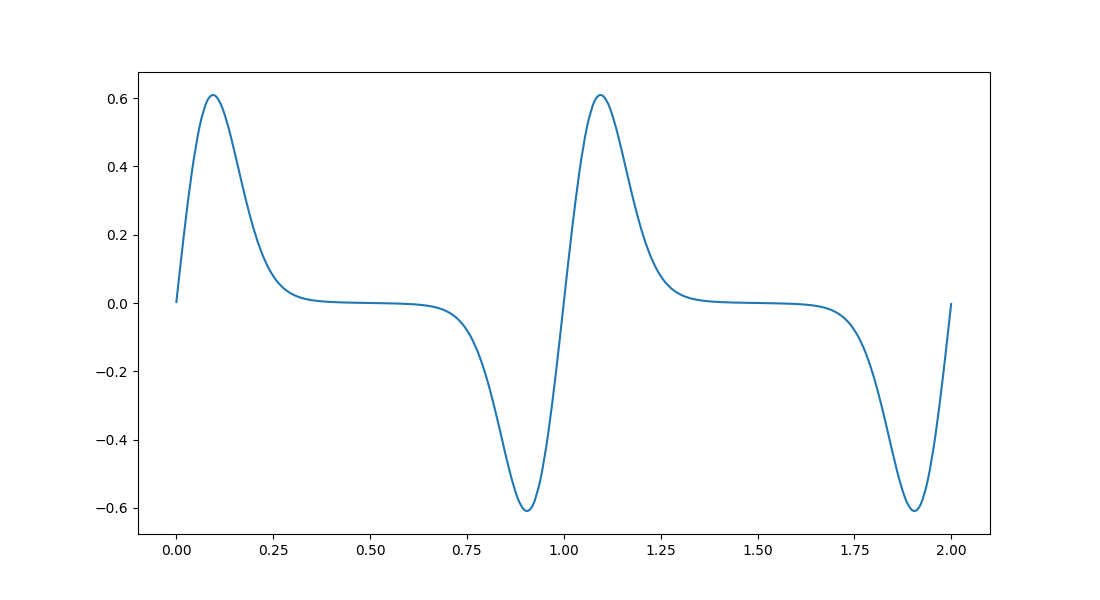

In [15]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import plot

fig, axes = plt.subplots()

paths=plot(dJ, axes=axes)

## Exercise 1

The reduced functional defines a function:

$$
\hat{J}(m) = J(u(m), m)
$$

Where $m$ is the control. As well as differentiating the functional, it's possible to evaluate it for a new intial condition. This is achieved by calling the reduced functional:

```python3
Jhat(u_new)
```

### a.
Try evaluating `Jhat` for a new initial condition. You'll still need to use a periodic funcition, but you could change the frequency of the wave, or try a more adventurous but still periodic function.

### b. 
You can access the solution of the last solve in the reduced functional with `get_solve_blocks()[-1].get_outputs()[0].saved_output`. See how the solution changes for different values of the initial condition.

### c.
The gradient returned by `Jhat.derivative()` is linearised around the solution for the last state at which the reduced functional was evaluated. Plot the gradient for different initial conditions and see if you can intuit why it looks like it does.


## Taylor tests

How do we know that the gradient we have calculated above is correct? The [Taylor test](https://www.firedrakeproject.org/adjoint.html#taylor-tests) provides us a very sensitive test of this. Almost any error in the computation of the gradient will cause its convergence rate to drop below 2. We evaluate the Taylor test at our original functional and with a perturbation of a constant function:

In [33]:
taylor_test(Jhat, u_init, assemble(interpolate(Constant(1.), V))) 

Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]
Evaluating adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 22/154 [0:00:00]

Running Taylor test


Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]
Evaluating functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 154/154 [0:00:00]

Computed residuals: [0.0001965555602045378, 4.9139592133873914e-05, 1.2284943066543121e-05, 3.071238598884181e-06]
Computed convergence rates: [np.float64(1.9999793873233689), np.float64(1.9999947114844419), np.float64(1.9999986695684902)]


np.float64(1.9999793873233689)

## Examining the adjoint calculation

When we first studied the Burgers equation we plotted an animation of the solution over time. As a reminder:

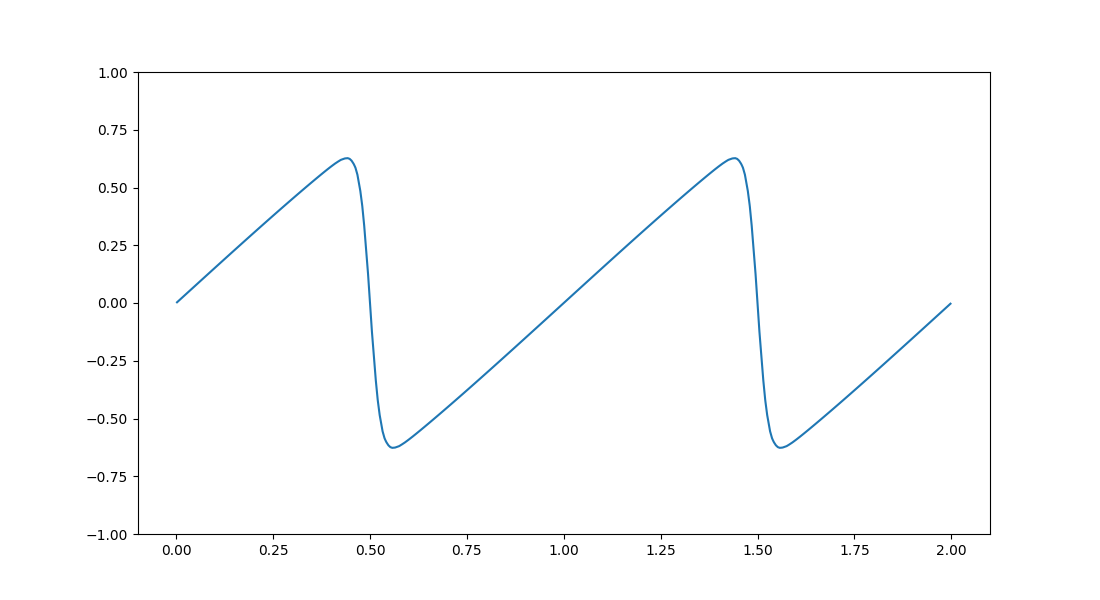

In [40]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import plot
from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots()

def animate(u):
    axes.clear()
    plot(u, axes=axes)
    axes.set_ylim((-1., 1.))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

In order to understand how the adjoint solution works, it's helpful to do the same for the adjoint. We can extract the adjoint solutions to the PDE for each timestep as follows:

In [36]:
adjoints = [block.get_dependencies()[0].adj_value for block in get_solve_blocks()[::-1]]

We deliberately extracted the blocks in reverse order because the adjoint is solved in reverse order. The adjoint value of the control is the last solve value in the sequence so we add that:

In [37]:
adjoints += [Jhat.controls[0].adj_value]

Now, if we take a look at those variables...

In [38]:
adjoints

[Cofunction(FiredrakeDualSpace(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1514bf750>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 6)), 6589),
 Cofunction(FiredrakeDualSpace(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1514bf750>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 6)), 6600),
 Cofunction(FiredrakeDualSpace(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1514bf750>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 6)), 6611),
 Cofunction(FiredrakeDualSpace(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1514bf750>, FiniteElement('Lagrange', interval, 2), n

The adjoint variables are, as expected, cofunctions. To recover the adjoint solutions in a form we can visualise, we take the Riesz represntation to recover Functions:

In [39]:
adjoints = [a.riesz_representation(riesz_map="L2") for a in adjoints if a] 

Now we can visualise the adjoint solution:

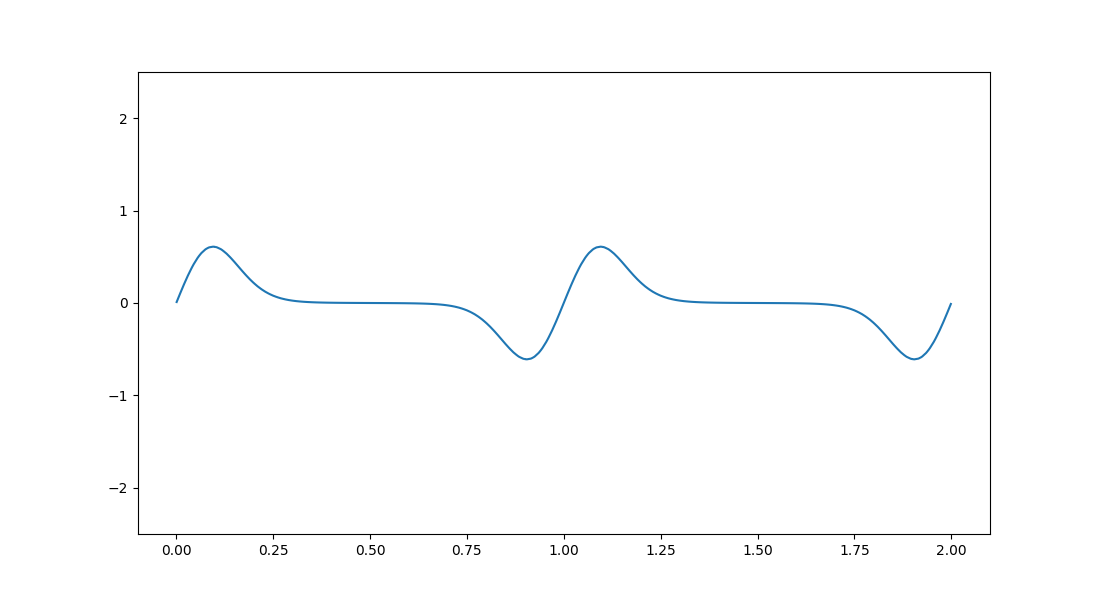

In [41]:
fig, axes = plt.subplots()

def animate(u):
    axes.clear()
    plot(u, axes=axes)
    axes.set_ylim((-2.5, 2.5))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=adjoints, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

## Exercise 2

Go back to the Poisson equation example, and solve Poisson's equation with Dirichlet boundary conditions. Find $u$ such that:
$$
\begin{gather*}
-\nabla^2 u = f \qquad x\in \Omega\\
u = 0 \qquad x \in \Gamma
\end{gather*}
$$
Choose a suitable forcing function $f$ and evaluate the functional:
$$
J = \int_\Omega u^2 + f^2\,\mathrm{d}x
$$
Create a reduced functional and conduct a Taylor test in order to establish that your implementation is correct.
Before you start, you will need to remove the recording of the Burgers equation from the tape:

In [45]:
get_working_tape().clear_tape()
continue_annotation()

True

## Visualising the tape

An exceptionally useful aid to understanding the computation of the adjoint is to produce a visual representation of the tape. To produce a managable sized figure, we'll rerun the Burgers equation with just 5 timesteps:

In [51]:
tape=get_working_tape()
continue_annotation()
tape.clear_tape()
u_n.assign(u_init)
timesteps = 5
for t in ProgressBar("Time step").iter(range(timesteps)):
    solver.solve()
    u_n.assign(u_n1)
J = assemble(u_n*u_n*dx)
pause_annotation()

Time step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 5/5 [0:00:00]


In [52]:
tape.visualise("tape.pdf")

In [53]:
!pip install pdf2image


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


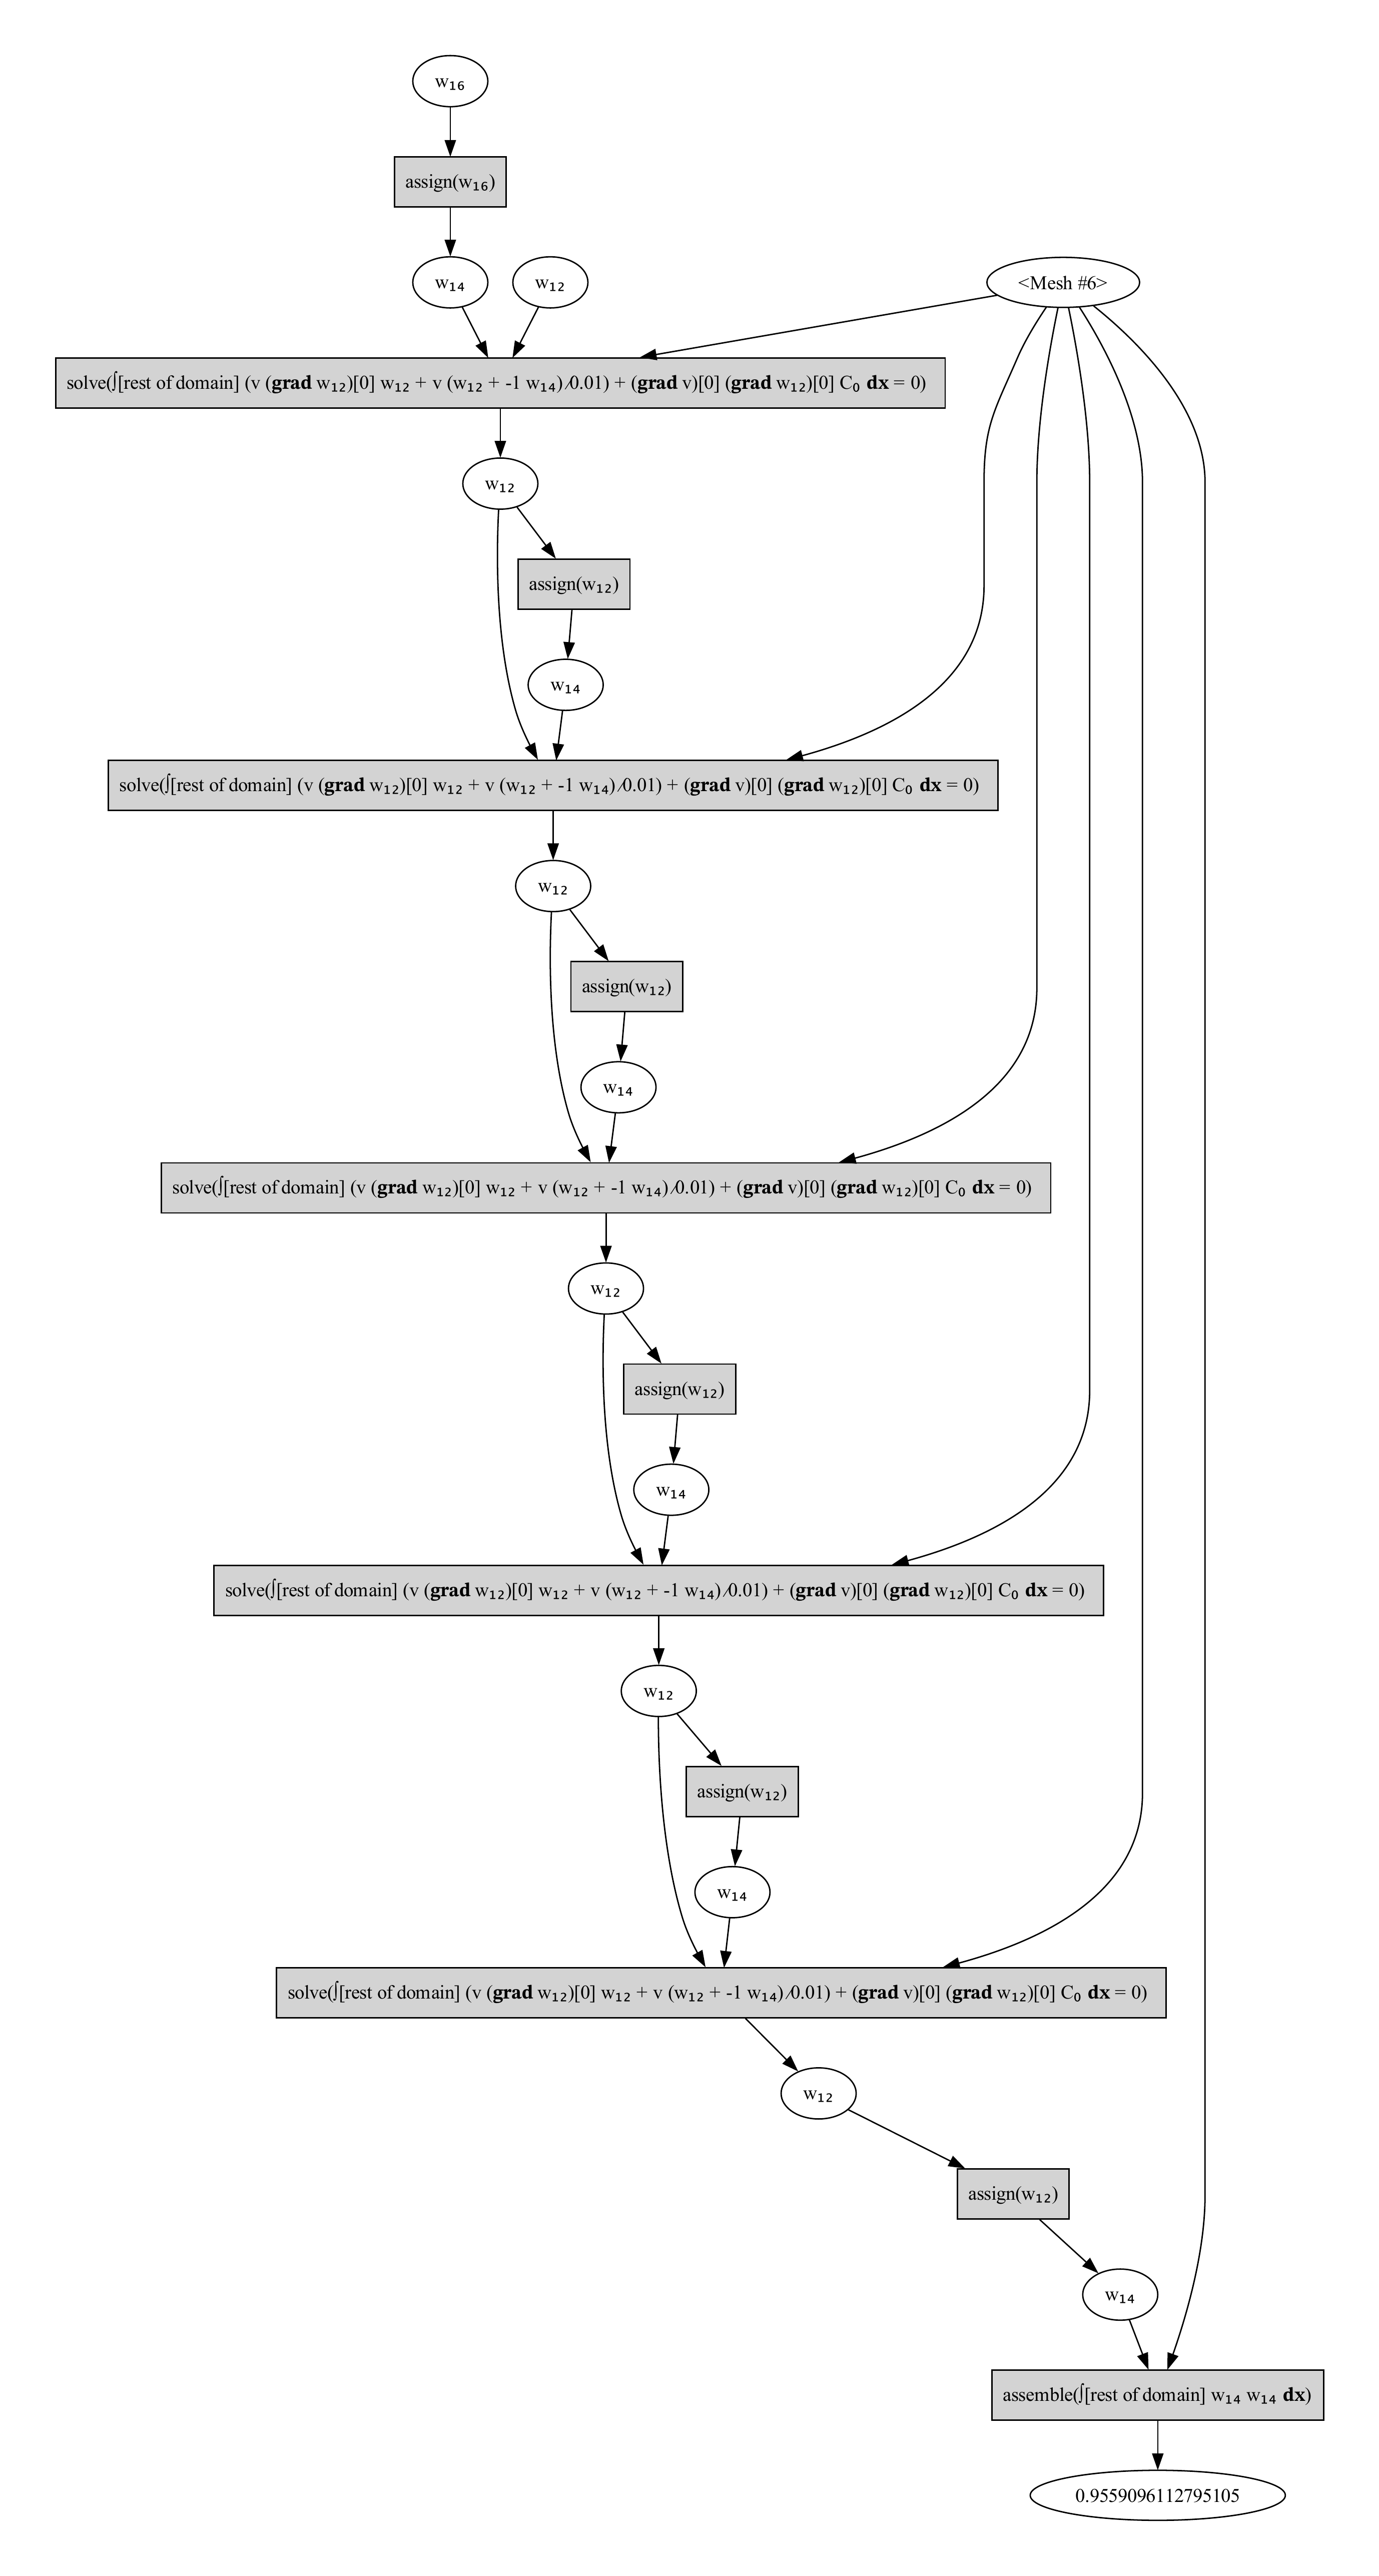

In [54]:
from pdf2image import convert_from_path

images = convert_from_path("tape.pdf")
images[0]  # first page